<a href="https://colab.research.google.com/github/AmritangshuM/multi-class-wildlife-detection-yolo/blob/main/Data_Processing_YOLO_V5_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download -d antoreepjana/animals-detection-images-dataset
!unzip /content/animals-detection-images-dataset.zip

In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/AMLTermProject')

In [ ]:
#!unzip /content/gdrive/MyDrive/CollabDatasets/animals-detection-images-dataset.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt


#data_dir="/content/gdrive/MyDrive/AMLTermProject"
data_dir="/content"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

train_classes=[os.path.basename(path) for path in all_train_subdir]
test_classes=[os.path.basename(path) for path in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

train_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_train_subdir}
test_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_test_subdir}

train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df



There is 80 classes in train dataset, and 80 classes in test dataset


,train,test
Kangaroo,98,43
Bull,47,73
Panda,91,19
Whale,287,52
Mouse,151,83
...,...,...
Zebra,181,31
Snail,370,114
Bear,87,39
Giraffe,298,23


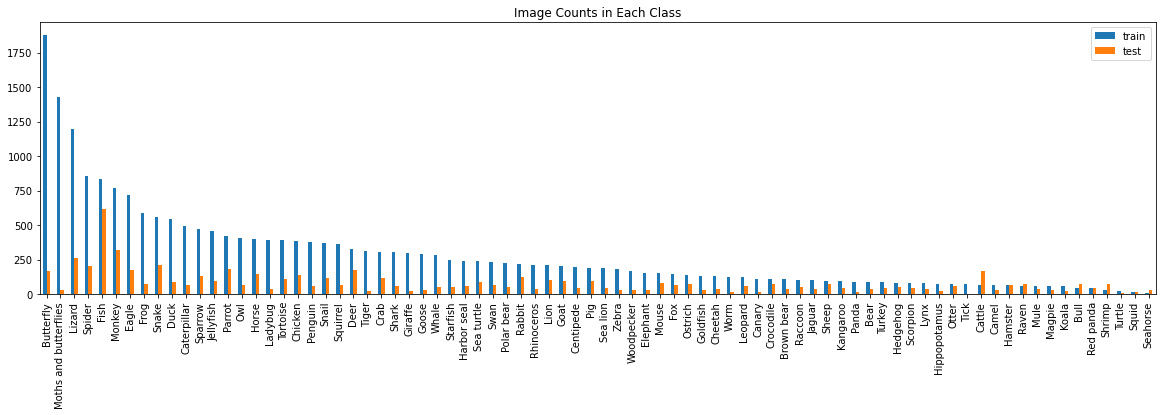

In [ ]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

In [ ]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))    
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])
        
            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)
        
    return image


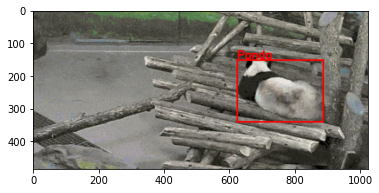

In [ ]:
subdir = all_train_subdir[2]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [ ]:
#os.chdir('/content/gdrive/MyDrive/AMLTermProject')

yolo_train_dir = "/content/yolo/train"
yolo_test_dir = "/content/yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

/content/yolo/train/images
/content/yolo/train/labels
/content/yolo/test/images
/content/yolo/test/labels


In [ ]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            #print('check')
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue
            if os.path.exists(label_file)==False:
                continue

            #print('check1')       
            image = cv2.imread(image_file)                
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        #print('check2')
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)
    

In [ ]:
os.chdir('/content/gdrive/MyDrive/AMLTermProject')

In [ ]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 665762.54it/s]


In [ ]:
# process_dataset(all_train_subdir, yolo_train_dir, train_classes, size=(640,640), link=False)        
xueqin_train_subdir=all_train_subdir
xueqin_classes=[os.path.basename(pp) for pp in xueqin_train_subdir]

process_dataset(xueqin_train_subdir, yolo_train_dir, xueqin_classes, size=(640,640), link=False) 

100%|██████████| 80/80 [08:23<00:00,  6.29s/it]


In [ ]:
xueqin_test_subdir=all_test_subdir
process_dataset(xueqin_test_subdir, yolo_test_dir, xueqin_classes, size=(640,640), link=False)  

100%|██████████| 80/80 [02:28<00:00,  1.86s/it]


In [ ]:
%cp -av /content/gdrive/MyDrive/AMLTermProject/yolo /content/yolo

In [ ]:
!ls /content/gdrive/MyDrive/AMLTermProject/

test  train  yolo  yolov5


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
%cd -

In [ ]:
!cat /content/yolov5/data/coco.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# COCO 2017 dataset http://cocodataset.org by Microsoft
# Example usage: python train.py --data coco.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco  ← downloads here (20.1 GB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco  # dataset root dir
train: train2017.txt  # train images (relative to 'path') 118287 images
val: val2017.txt  # val images (relative to 'path') 5000 images
test: test-dev2017.txt  # 20288 of 40670 images, submit to https://competitions.codalab.org/competitions/20794

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  

In [ ]:
yaml_file="/content/yolov5/data/animal_detect1.yaml"
train_images_dir = os.path.join("..", yolo_train_dir, "images")
val_images_dir = os.path.join("..", yolo_test_dir, "images")

names_str=""
for item in xueqin_classes:
    names_str=names_str + ", \'%s\'"%item
names_str= "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(xueqin_classes))
    wobj.write(names_str+"\n")

In [ ]:
!cat /content/yolov5/data/animal_detect1.yaml

train: /content/yolo/train/images
val: /content/yolo/test/images
nc: 80
names: [ 'Kangaroo', 'Bull', 'Panda', 'Whale', 'Mouse', 'Parrot', 'Rhinoceros', 'Ladybug', 'Starfish', 'Scorpion', 'Tiger', 'Horse', 'Magpie', 'Goose', 'Squirrel', 'Brown bear', 'Duck', 'Camel', 'Monkey', 'Shark', 'Harbor seal', 'Deer', 'Raven', 'Squid', 'Polar bear', 'Raccoon', 'Leopard', 'Sea lion', 'Woodpecker', 'Eagle', 'Snake', 'Tortoise', 'Fox', 'Mule', 'Lizard', 'Jaguar', 'Swan', 'Goldfish', 'Pig', 'Otter', 'Hedgehog', 'Centipede', 'Jellyfish', 'Cattle', 'Caterpillar', 'Koala', 'Turkey', 'Turtle', 'Sea turtle', 'Sparrow', 'Canary', 'Seahorse', 'Red panda', 'Worm', 'Frog', 'Rabbit', 'Hamster', 'Crocodile', 'Lynx', 'Chicken', 'Moths and butterflies', 'Spider', 'Ostrich', 'Elephant', 'Owl', 'Tick', 'Lion', 'Butterfly', 'Fish', 'Crab', 'Sheep', 'Goat', 'Shrimp', 'Hippopotamus', 'Cheetah', 'Zebra', 'Snail', 'Bear', 'Giraffe', 'Penguin']


In [ ]:
!pip install "wandb==0.12.10"
import wandb
wandb.login()

In [ ]:
!python /content/yolov5/train.py --data /content/yolov5/data/animal_detect1.yaml --weights yolov5s.pt --batch-size 16 --name Model --img 640 --epochs 100 

wandb: Currently logged in as: amritangshu (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=, data=/content/yolov5/data/animal_detect1.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp -av /content/yolov5/runs /content/gdrive/My\ Drive/AML/yolov5_transfer/

'/content/yolov5/runs' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs'
'/content/yolov5/runs/train' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train'
'/content/yolov5/runs/train/Model' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train/Model'
'/content/yolov5/runs/train/Model/weights' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train/Model/weights'
'/content/yolov5/runs/train/Model/hyp.yaml' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train/Model/hyp.yaml'
'/content/yolov5/runs/train/Model/opt.yaml' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train/Model/opt.yaml'
'/content/yolov5/runs/train/Model/events.out.tfevents.1669113324.bbe5974bf6b3.536.0' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train/Model/events.out.tfevents.1669113324.bbe5974bf6b3.536.0'
'/content/yolov5/runs/train/Model/labels_correlogram.jpg' -> '/content/gdrive/My Drive/AML/yolov5_transfer/runs/train/Model/labels_correlogram.jpg'
'/content/yolov5/runs/

In [ ]:
#!python train.py --data data/animal.yaml --batch-size 32 --epochs 10 --img-size 640 --project runs/train --name animals --weights weights/yolov5s.pt --device 0

In [ ]:
#os.chdir('/content/gdrive/MyDrive/AMLTermProject')

In [ ]:
#!python /content/gdrive/MyDrive/AMLTermProject/yolov5/train.py --data /content/gdrive/MyDrive/AMLTermProject/yolov5/data/animal_detect1.yaml --weights yolov5s.pt --batch-size 8 --name Model --img 640 --epochs 100

requirements: YOLOv5 requirement "gitpython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['gitpython']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

train: weights=yolov5s.pt, cfg=, data=/content/gdrive/MyDrive/AMLTermProject/yolov5/data/animal_detect1.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch origin' ti

In [ ]:
!python /content/gdrive/MyDrive/AMLTermProject/yolov5/detect.py --weights /content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt --source /content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg --name animals --project runs/detect

detect: weights=['/content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt'], source=/content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=animals, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg: 640x640 (no detections), 13.5ms
Speed: 0.6ms pre-process, 13.5ms inference, 0.7ms NMS per image at shape (1, 3, 640, 640)
Results s

In [ ]:
!ls runs/detect/animals2/Bear_1fa809bf6cf5ea36.jpg

Bear_1fa809bf6cf5ea36.jpg


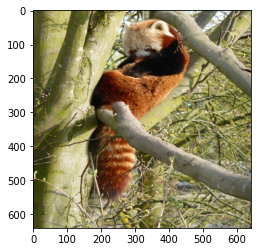

In [ ]:
img = cv2.imread("runs/detect/animals2/Bear_1fa809bf6cf5ea36.jpg")
plt.imshow(img[:,:,2::-1]);

In [ ]:
!python /content/gdrive/MyDrive/AMLTermProject/yolov5/export.py --weights /content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt --include onnx --simplify

export: data=yolov5/data/coco128.yaml, weights=['/content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs

PyTorch: starting from /content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt with output shape (1, 25200, 85) (14.2 MB)
requirements: YOLOv5 requirement "onnx" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['onnx']
requirements: ⚠️ Restart runtime or rerun command 

In [ ]:
#python train.py --data data.yaml --weights best.pt

In [ ]:
!pip install openimages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.6 MB/s 
     |████████████████████████████████| 132 kB 7.5 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 9.9 MB 47.4 MB/s 
     |████████████████████████████████| 140 kB 93.7 MB/s 
     |████████████████████████████████| 221.4 MB 22 kB/s 
     |████████████████████████████████| 296 kB 72.4 MB/s 
     |████████████████████████████████| 439 kB 95.2 MB/s 
     |████████████████████████████████| 1.7 MB 65.6 MB/s 
     |████████████████████████████████| 6.0 MB 80.2 MB/s 
     |████████████████████████████████| 127 kB 95.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    

In [ ]:
!oi_download_dataset --base_dir download --csv_dir download --labels Cat Dog --format darknet --limit 500

tcmalloc: large alloc 1194041344 bytes == 0x59dfa000 @  0x7fc240ca21e7 0x4b2590 0x5ad01c 0x5ad387 0x4d222f 0x51041f 0x4d14d6 0x57471e 0x50cb08 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x50e18c 0x5b4ee6 0x58ff2e 0x50d482 0x58fd37 0x50c4fc 0x5b4ee6 0x58ff2e 0x50c4fc 0x5b4ee6
2022-11-20  23:21:56 INFO Downloading 500 train images for class 'cat'
100% 500/500 [00:26<00:00, 18.99it/s]
2022-11-20  23:22:23 INFO Creating 500 train annotations (darknet) for class 'cat'
100% 500/500 [00:02<00:00, 206.09it/s]
2022-11-20  23:22:26 INFO Downloading 500 train images for class 'dog'
100% 498/500 [00:27<00:00, 22.25it/s]2022-11-20  23:22:53 WARNING Connection pool is full, discarding connection: open-images-dataset.s3.amazonaws.com
100% 500/500 [00:27<00:00, 18.19it/s]
2022-11-20  23:22:53 INFO Creating 500 train annotations (darknet) for class 'dog'
100% 500/500 [00:02<00:00, 207.02it/s]


In [ ]:
from PIL import Image, ImageDraw

def show_bbox(image_path):
    # convert image path to label path
    label_path = image_path.replace('/images/', '/darknet/')
    label_path = label_path.replace('.jpg', '.txt')

    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')

            # Convert string into float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=(255, 0, 0), # Red in RGB
                           width=5)             # Line width
    image.show()
    



In [ ]:
show_bbox('/content/gdrive/MyDrive/AMLTermProject/download/cat/images/0008ab3d8674f6ca.jpg')

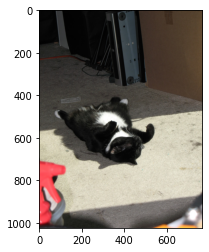

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/AMLTermProject/download/cat/images/0008ab3d8674f6ca.jpg")
plt.imshow(img[:,:,2::-1]);